# Applying Machine Learning Models

In [50]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [51]:
data1 = pd.read_csv('Data_UCI_not_noise_1.csv')
data2 = pd.read_csv('Data_UCI_not_noise_2.csv')

df_concat = pd.concat([data1, data2])

print(df_concat.shape)

(9233, 642)


In [52]:
features_act = list()
features_uid = list()

with open('act_feature_importance.txt', 'r') as f:
    features_act = f.read().splitlines()

with open('uid_feature_importance.txt', 'r') as f:
    features_uid = f.read().splitlines()

# print(features_act)
# print(features_uid)

In [53]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df, id):
  X = df.drop(['user_Id', 'activity_Id'], axis=1)
  y = df[id]

  return train_test_split(X, y, test_size=0.33, random_state=42) # X_train, X_test, y_train, y_test

  # for i in X_train.columns:
  #   print(X_train[i].dtype)
  # print(X_train.dtypes)

  # # 訓練用
  # X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_train = train['subject']

  # # テスト用
  # X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_test = test['subject']

  # print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
  # print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

Let's make a function to plot the confusion matrix

In [54]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [55]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(15, 15))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    # print('****************| Classifiction Report |****************')
    # classification_report = metrics.classification_report(y_test, y_pred)
    
    # # store report in results
    # results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [56]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

In [57]:
labels_act = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

labels_uid = list()
for i in range(1, 31):
    labels_uid.append(i)

In [58]:
n = 211
f_add_weighted_noise = set()
for f in features_uid[:n]:
  # 重複していないものを入れる
  if f not in features_act[:n]:
    f_add_weighted_noise.add(f)
print(len(f_add_weighted_noise))

111


In [59]:
weighted_epsilon_array = [0.001, 0.005, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05]

weighted_epsilon = weighted_epsilon_array[0]

## 2. Random Forest Classifier

## UID

--------
epsilon:  1.0
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:05:41.331272

Predicting test data
==> testing time:- 0:00:00.447519

==> Accuracy:- 0.04529044962257959


 ********Confusion Matrix********

 [[ 6  0  0  0  0  0  0  0  0  0  0  0  0  1  0  2  1  9  0  0 16  0  0  7
  27 40  6  0  2  3]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  2  3  0  0 16  0  0 13
  13 46  2  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  6  3  0  0 16  0  0  8
  15 41  2  0  2  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  3  0  0  6  0  1 10
  17 43  2  1  1  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  5  4  2  0  0  3  0  0 11
   8 52  1  0  0  2]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  4  0  0  8  0  0 14
  11 42  2  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  1  2  0  0 13  0  0 11
  13 30  3  0  2  3]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

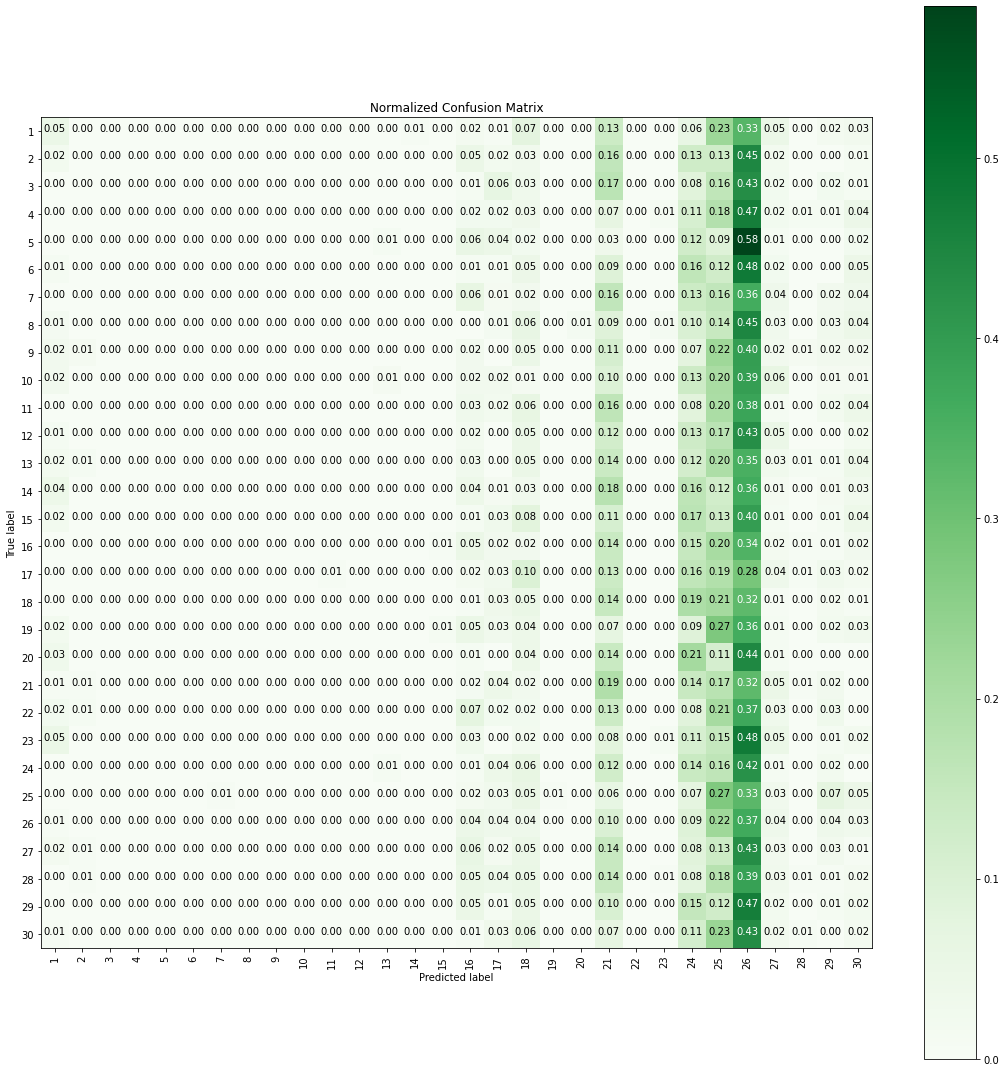


 F1 Score:0.020742796410887835


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.05544786947419561
--------
epsilon:  1.1
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:05:33.153977

Predicting test data
==> testing time:- 0:00:00.107098

==> Accuracy:- 0.04791598293403348


 ********Confusion Matrix********

 [[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  3  9  0  0 11  0  3 16
  18 27  3  0  1 11]
 [ 1  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  3  5  0  0 13  1  1 13
  18 27 11  0  5  2]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  7  5  0  1 19  0  2 12
  12 23  6  0  1  1]
 [ 4  0  0  0  0  0  1  0  0  0  0  1  2  0  0  2  7  9  0  0  5

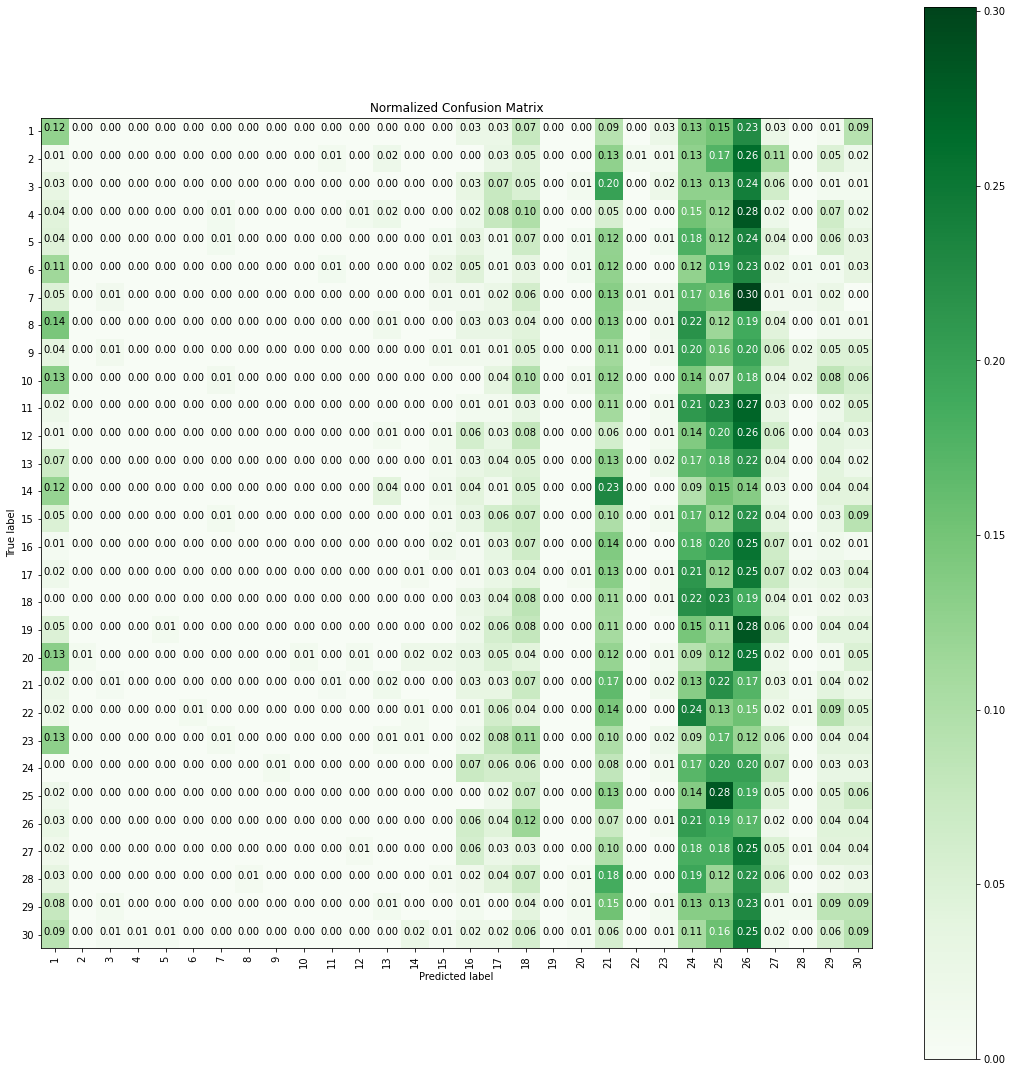


 F1 Score:0.0256506794213103


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.056580554079061984
--------
epsilon:  1.2
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:22:41.034064

Predicting test data
==> testing time:- 0:00:00.166219

==> Accuracy:- 0.05316704955694125


 ********Confusion Matrix********

 [[ 6  1  0  0  0  0  0  1  0  0  0  0  2  0  0  1  4  5  0  1 15  0  3 24
  24 20  3  0  6  4]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  2  3  0  0 14  0  0 19
  21 25  8  1  2  1]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  1  0  1  0  2  3  0  0 14  0  0 20
  22 23  5  0  3  0]
 [ 1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  2  1  8  0  0  8 

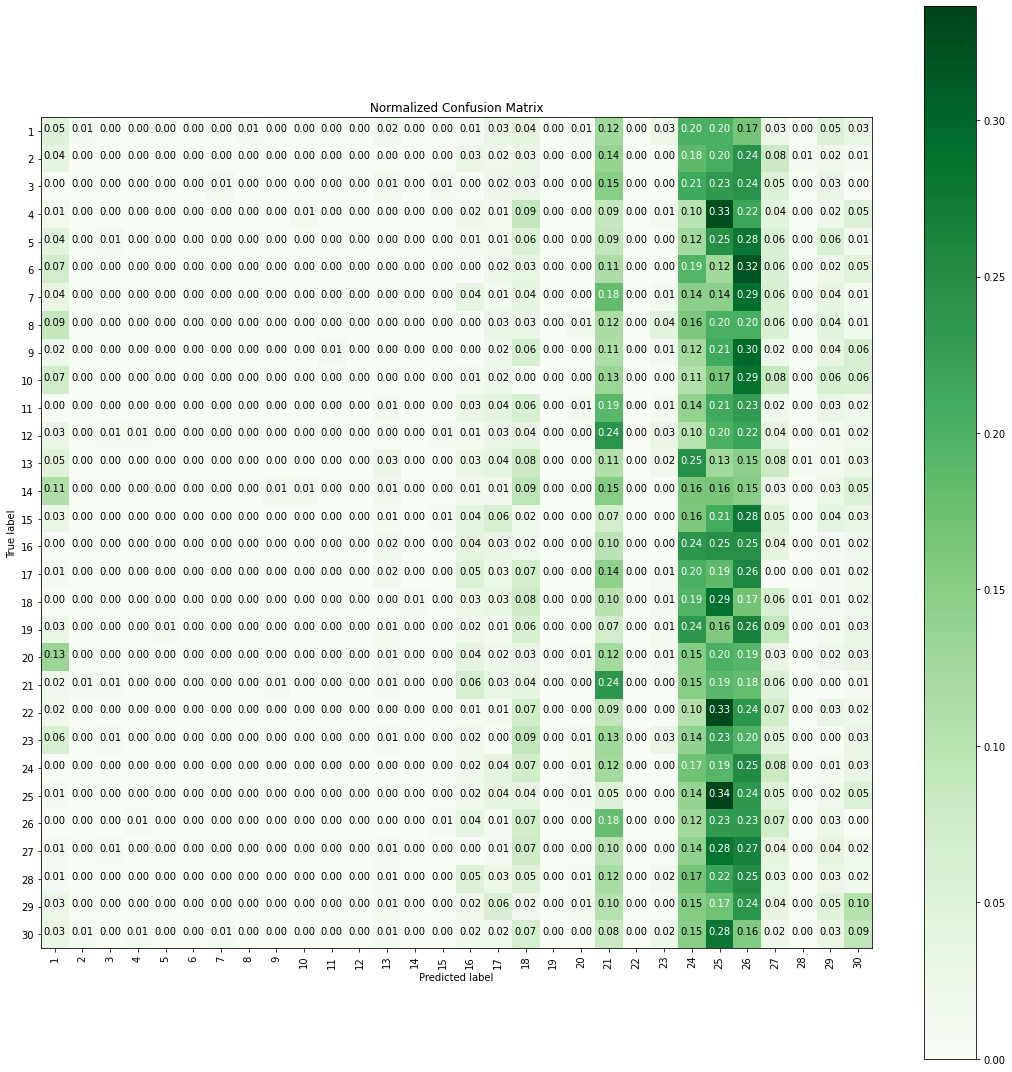


 F1 Score:0.028888031264509208


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.058033989680071785
--------
epsilon:  1.3
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:09:00.306728

Predicting test data
==> testing time:- 0:00:00.128630

==> Accuracy:- 0.062356416147029865


 ********Confusion Matrix********

 [[25  2  0  0  0  0  1  1  0  2  2  0  5  0  1  1  6 14  1  3 11  0  2  8
  18  5  5  1  3  3]
 [ 7  0  1  0  0  0  1  0  0  0  0  0  2  0  2  3  7  4  0  0 11  0  5 12
  17 18  2  1  7  3]
 [ 2  1  0  0  0  0  1  0  0  0  0  0  4  0  1  1  5  7  0  0  6  2  1 12
  19 22  3  1  2  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  5  5  9  0  0 

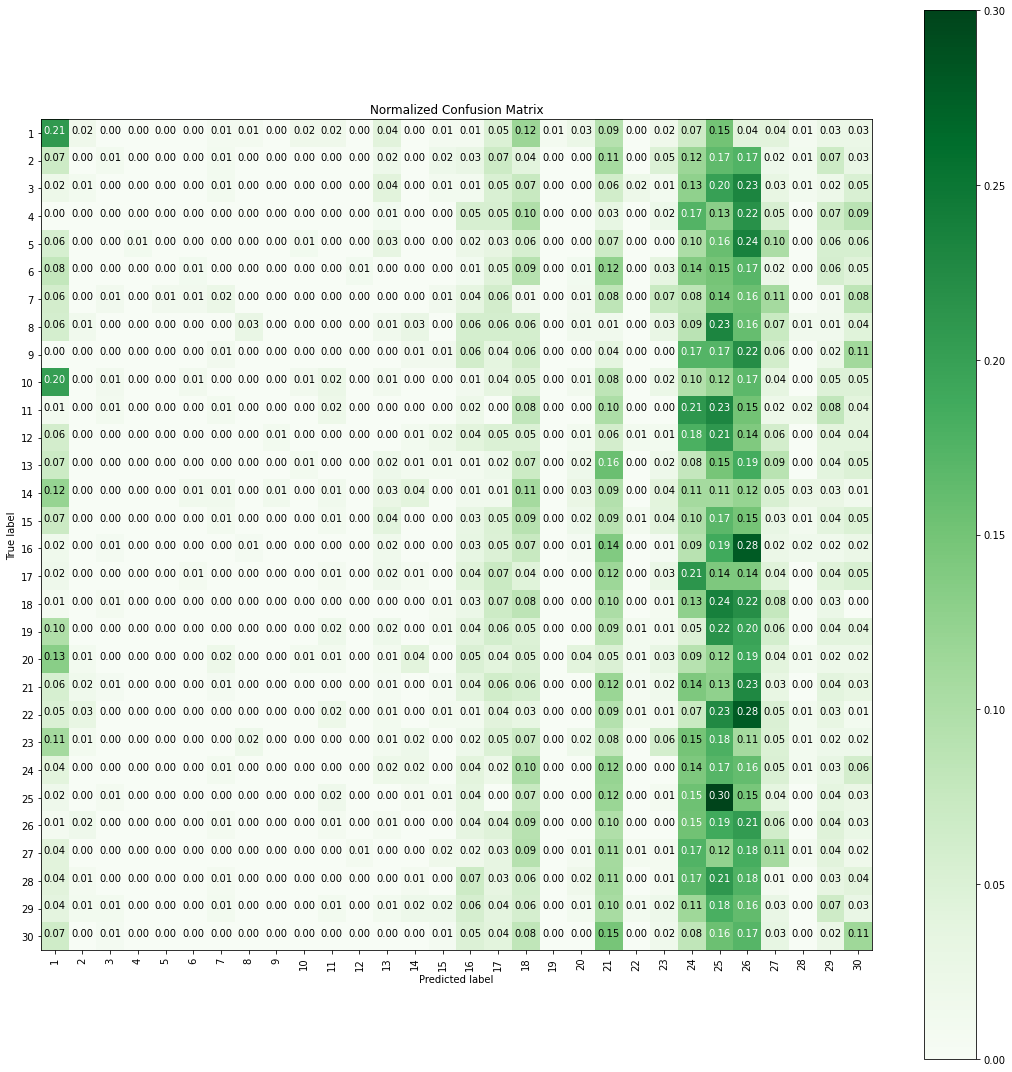


 F1 Score:0.044099764501131386


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.060944125855586305
--------
epsilon:  1.4
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:06:11.540755

Predicting test data
==> testing time:- 0:00:00.165773

==> Accuracy:- 0.06924844108959632


 ********Confusion Matrix********

 [[23  0  0  0  0  0  0  0  0  0  0  0  3  5  1  3  5 10  0  1 13  0  3  8
  12 18  4  1  7  3]
 [ 8  0  2  0  0  0  0  0  0  0  0  0  0  1  0  4  2  7  0  0 15  0  0 16
  14 19  6  0  5  4]
 [ 3  0  4  1  0  0  0  0  0  0  1  0  0  1  0  2  6  5  0  0  9  0  0 19
  11 17  6  0  7  3]
 [ 1  0  0  0  0  0  0  2  0  1  0  1  1  0  1  4  4  3  0  0

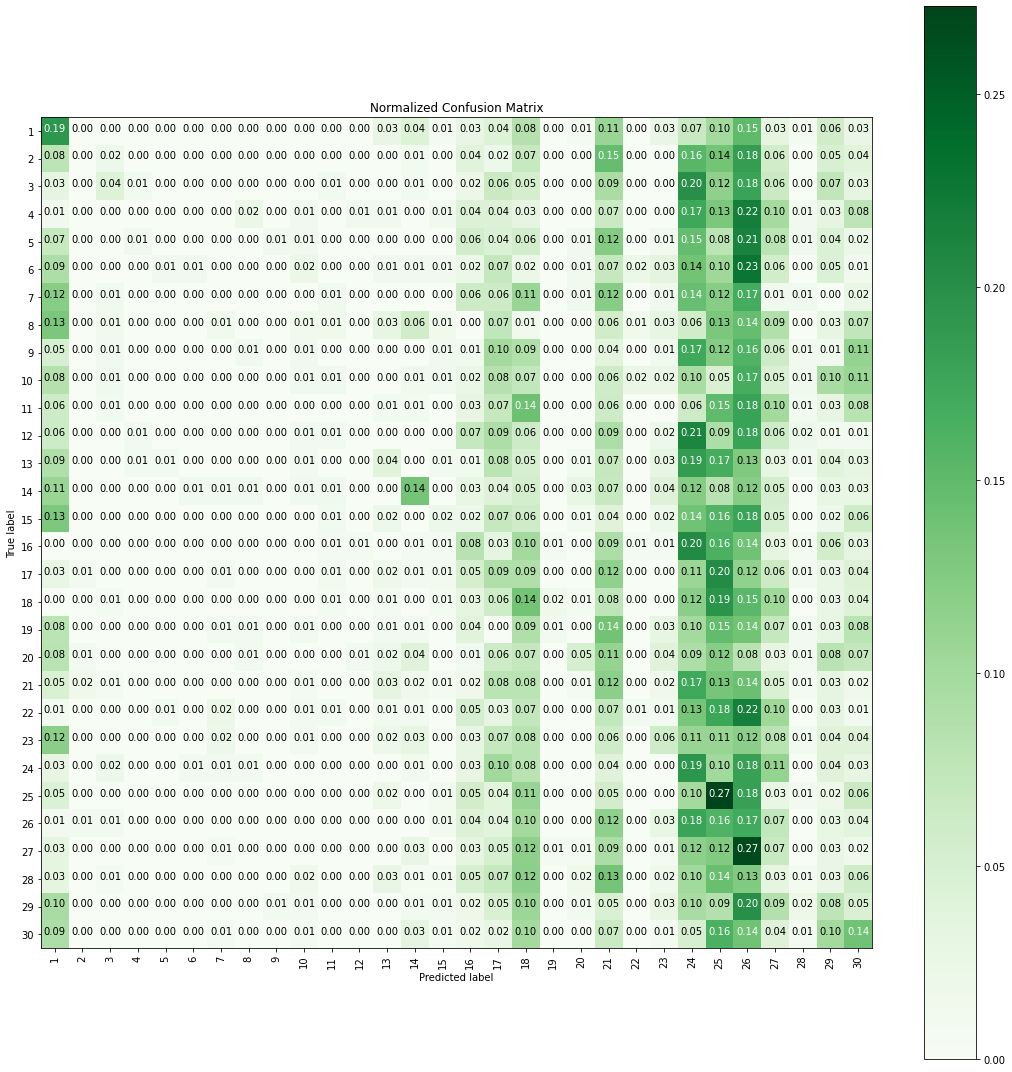


 F1 Score:0.051856767559711935


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.06660428390642324
--------
epsilon:  1.5
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:09:10.260194

Predicting test data
==> testing time:- 0:00:00.194226

==> Accuracy:- 0.0781096160157532


 ********Confusion Matrix********

 [[31  0  0  0  0  0  1  1  0  0  0  0  0  0  0  1  2  4  0  0  7  0  2 12
  29 11  4  1  5  9]
 [ 3  0  0  0  0  0  1  0  0  0  0  0  1  3  0  4  1  6  0  0 17  0  0 15
  14 25  5  0  5  3]
 [ 4  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  4  5  0  0  7  0  3 12
  22 23  7  0  0  5]
 [ 0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  4  1  6  0  0  

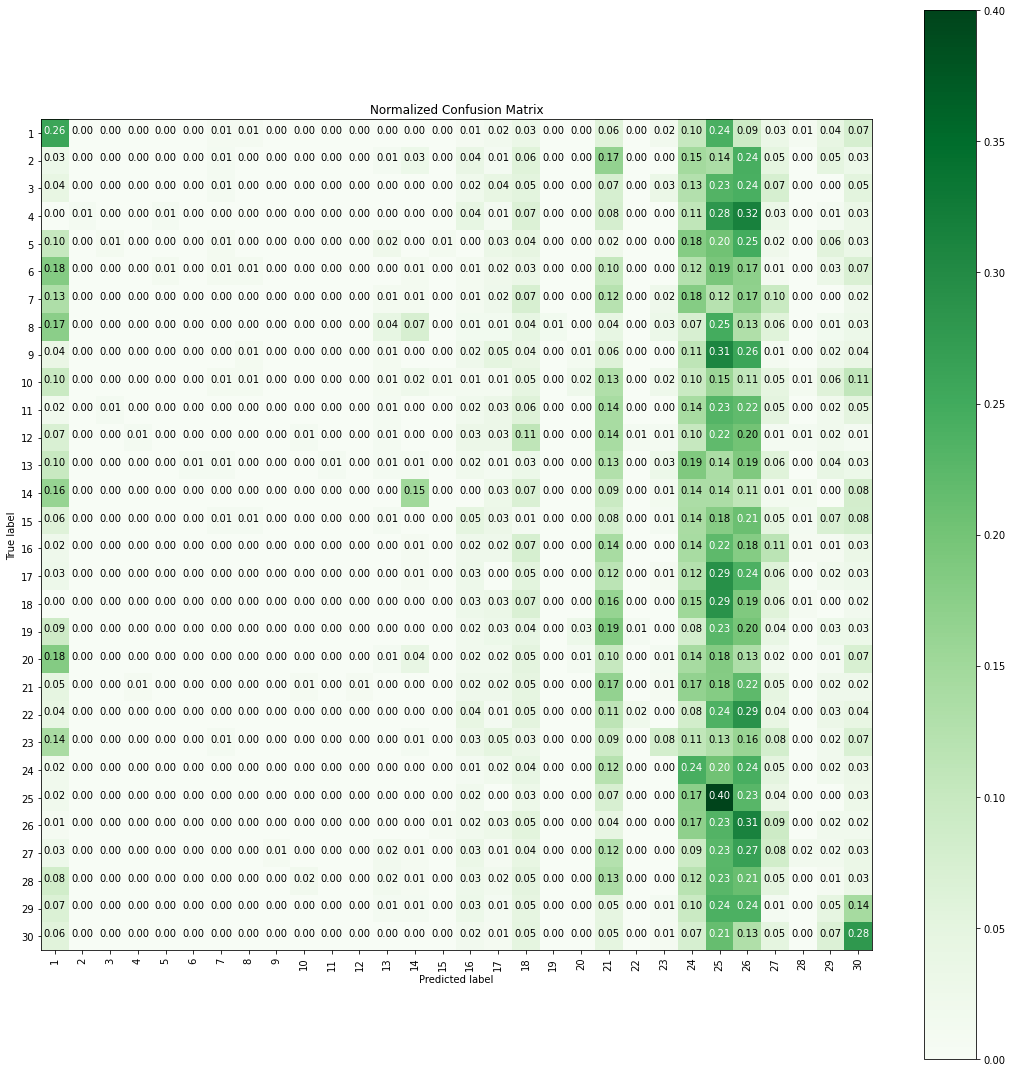


 F1 Score:0.04787303312368969


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.07694824233416873
--------
epsilon:  1.8
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:09:13.221969

Predicting test data
==> testing time:- 0:00:00.158567

==> Accuracy:- 0.09944207417131605


 ********Confusion Matrix********

 [[37  0  0  0  1  0  1  0  0  0  0  0  3  2  0  5  6  8  0  5  3  0  5 10
   8  6  9  1  4  6]
 [ 6  4  2  0  2  0  0  1  0  1  0  0  2  2  0  1  3  6  0  0 13  0  0 11
   8 28  7  0  3  3]
 [ 3  1  1  1  0  0  0  1  0  0  0  0  0  1  0  3  5 12  0  0 12  0  0 13
  15 16  6  1  1  3]
 [ 2  0  1  1  0  0  0  0  0  2  0  0  0  1  0  0  1  2  0  0  7 

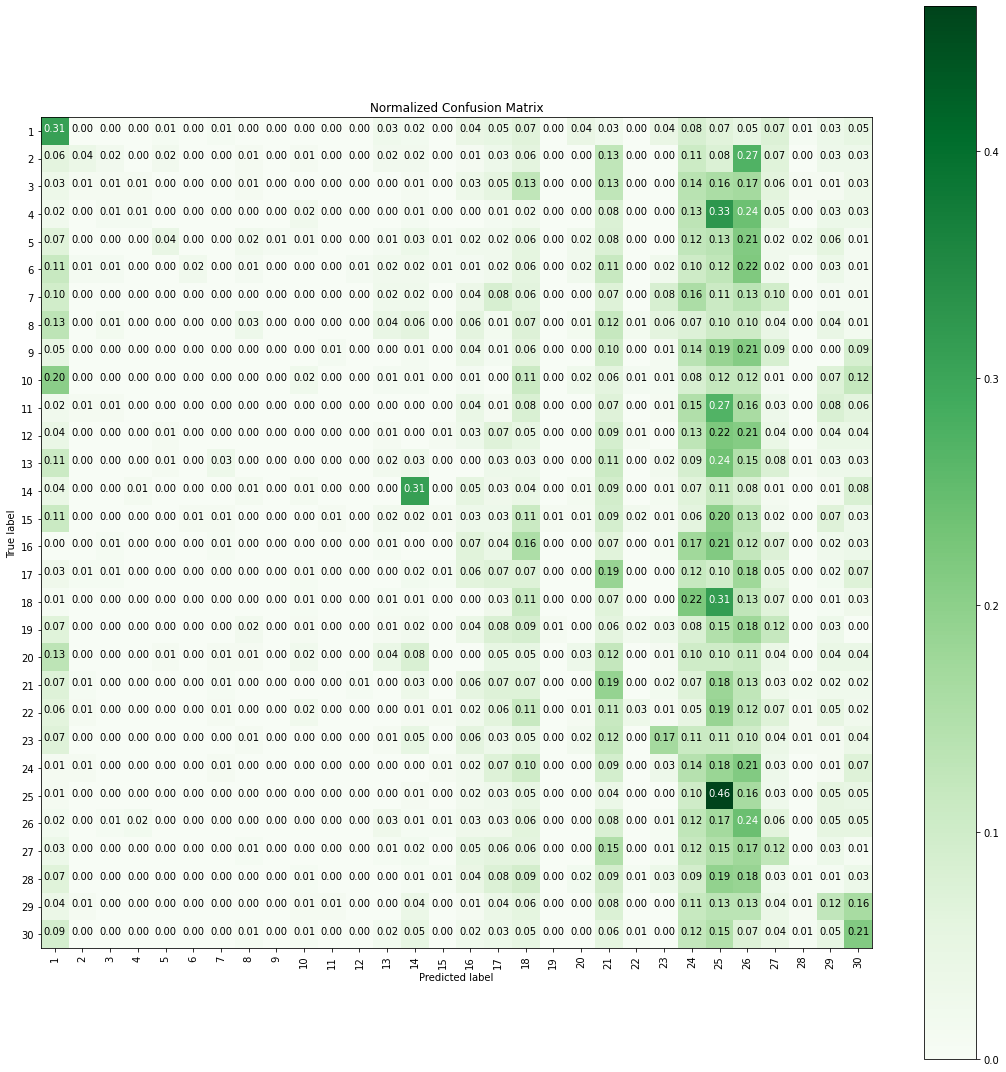


 F1 Score:0.07653627221941336


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.09311155892036468
--------
epsilon:  2.0
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:09:33.936402

Predicting test data
==> testing time:- 0:00:00.188312

==> Accuracy:- 0.11552346570397112


 ********Confusion Matrix********

 [[42  0  0  0  0  0  0  0  0  0  0  0  1  1  0  3  1  5  0  3  3  0  1  5
  19 18  1  0  8  9]
 [ 3  1  1  0  0  0  0  0  0  1  0  0  1  1  0  2  6  3  0  0 12  1  2 20
  15 25  3  0  1  5]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3 13  0  1 11  2  1  7
  14 31  2  0  3  4]
 [ 6  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  2  0  0  7 

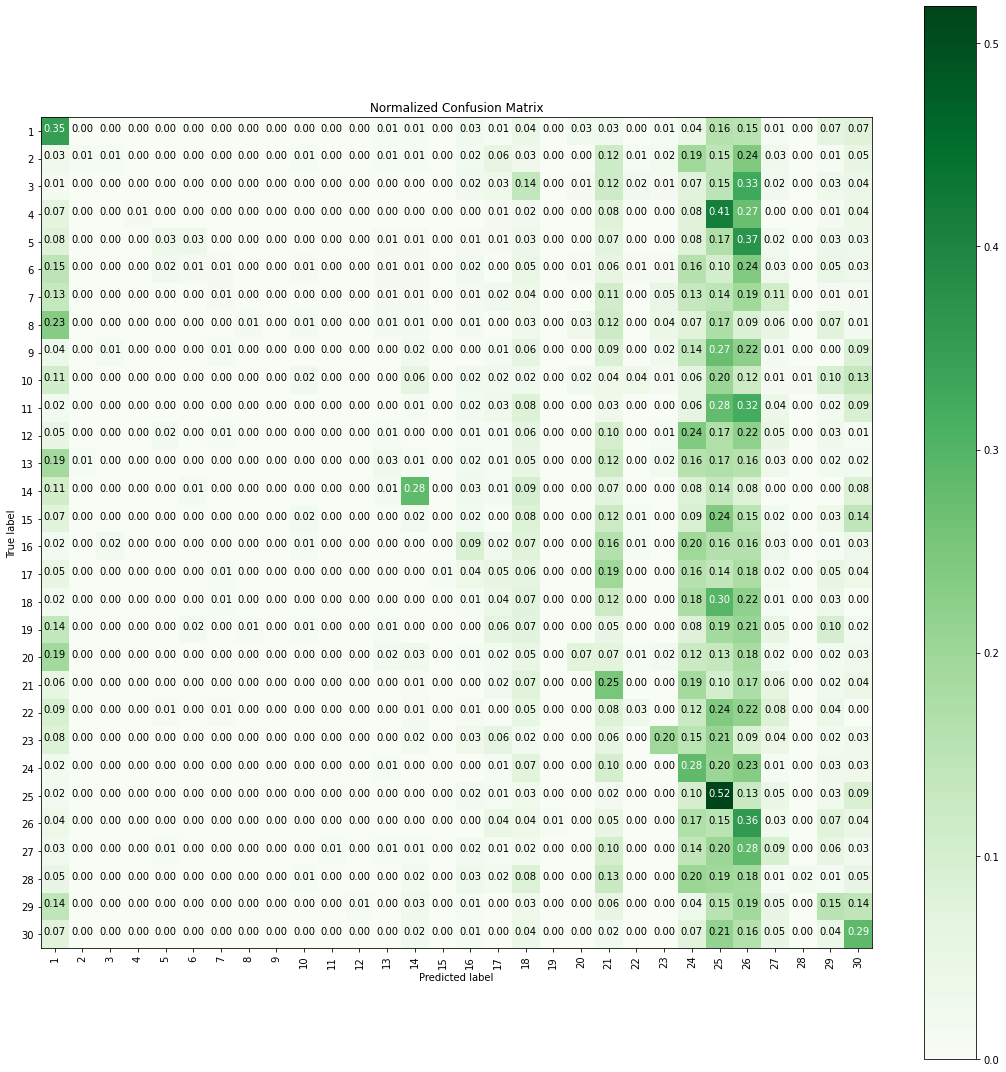


 F1 Score:0.08559790189381035


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.11396768721031522
--------
epsilon:  2.2
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [60]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_uid = list()


epsilons = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2.0, 2.2, 2.5]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

  for col in X_train:
      # default sensitivity = 1.0
    # if col not in f_add_weighted_noise:
    #   # print("------epsilon--------")
    #   # display(X_train[col].head())
    #   X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    #   X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    #   # display(X_train[col].head)
    # else:
    #   # print("------weighted_epsilon--------")
    #   # display(X_train[col].head())
    #   X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    #   X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    #   # display(X_train[col].head())
    
    if col in f_add_weighted_noise:
          # print("------epsilon--------")
      # display(X_train[col].head())
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      # display(X_train[col].head)
      # print("------weighted_epsilon--------")
      # display(X_train[col].head())
    X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    # display(X_train[col].head())
  
  # params = {'n_estimators': np.arange(120,201,20), 'max_depth':np.arange(6,15,2)}
  params = {'n_estimators': np.arange(120,151,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid,  X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_uid)
  acc_array_random_uid.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], acc_array_random_uid[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()


# HAR

--------
epsilon:  1.0
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:02:45.195019

Predicting test data
==> testing time:- 0:00:00.063875

==> Accuracy:- 0.5979652116836233


 ********Confusion Matrix********

 [[441  31  58   0   9   2]
 [325  90  54   1  14   8]
 [150  25 250   0   1   2]
 [  2   1   0  79 325  99]
 [  0   1   0  46 438  48]
 [  0   0   0   4  19 524]]


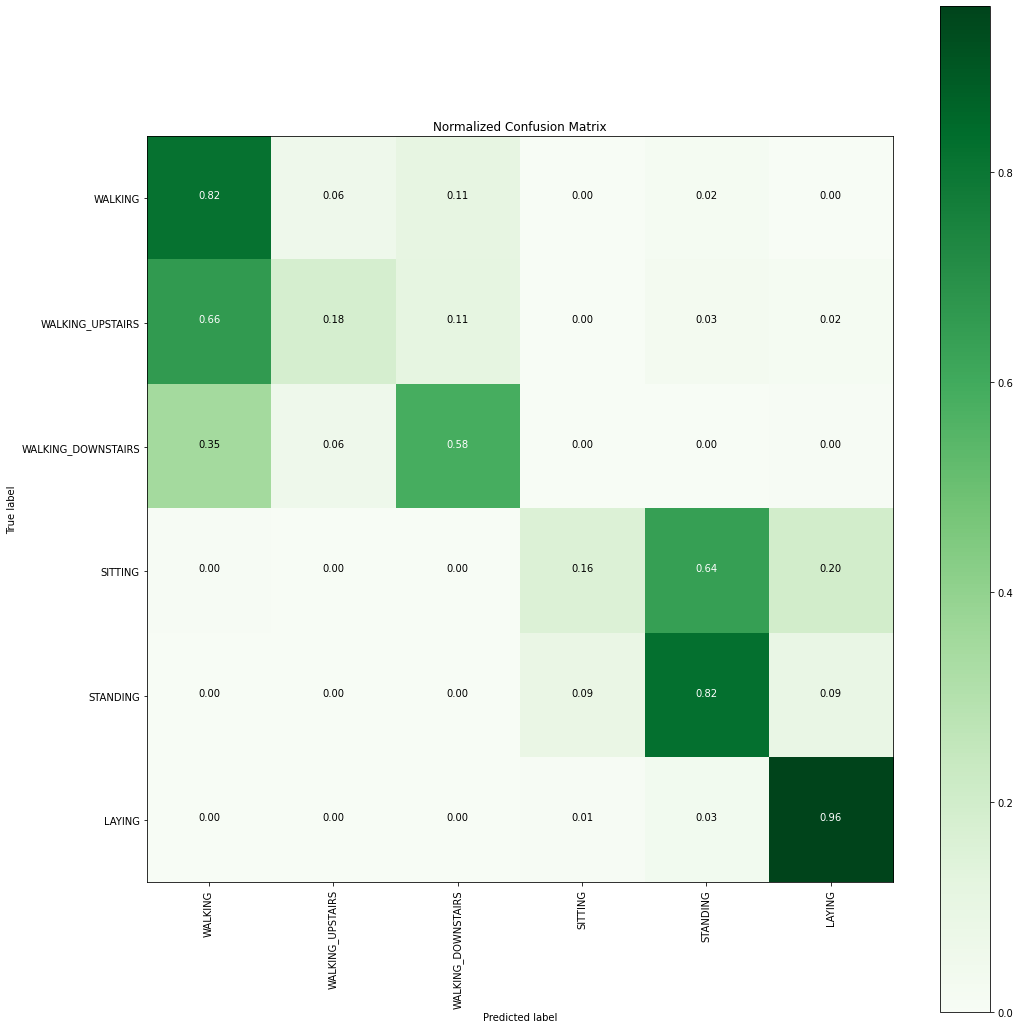


 F1 Score:0.5455607998100455


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6045921199211705
--------
epsilon:  1.1
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:02:34.030600

Predicting test data
==> testing time:- 0:00:00.068386

==> Accuracy:- 0.6291434197571382


 ********Confusion Matrix********

 [[436  33  62   0   7   3]
 [281 131  61   1  14   4]
 [147  26 252   0   1   2]
 [  0   0   0 104 335  67]
 [  0   0   0  38 462  33]
 [  0   0   0   2  13 532]]


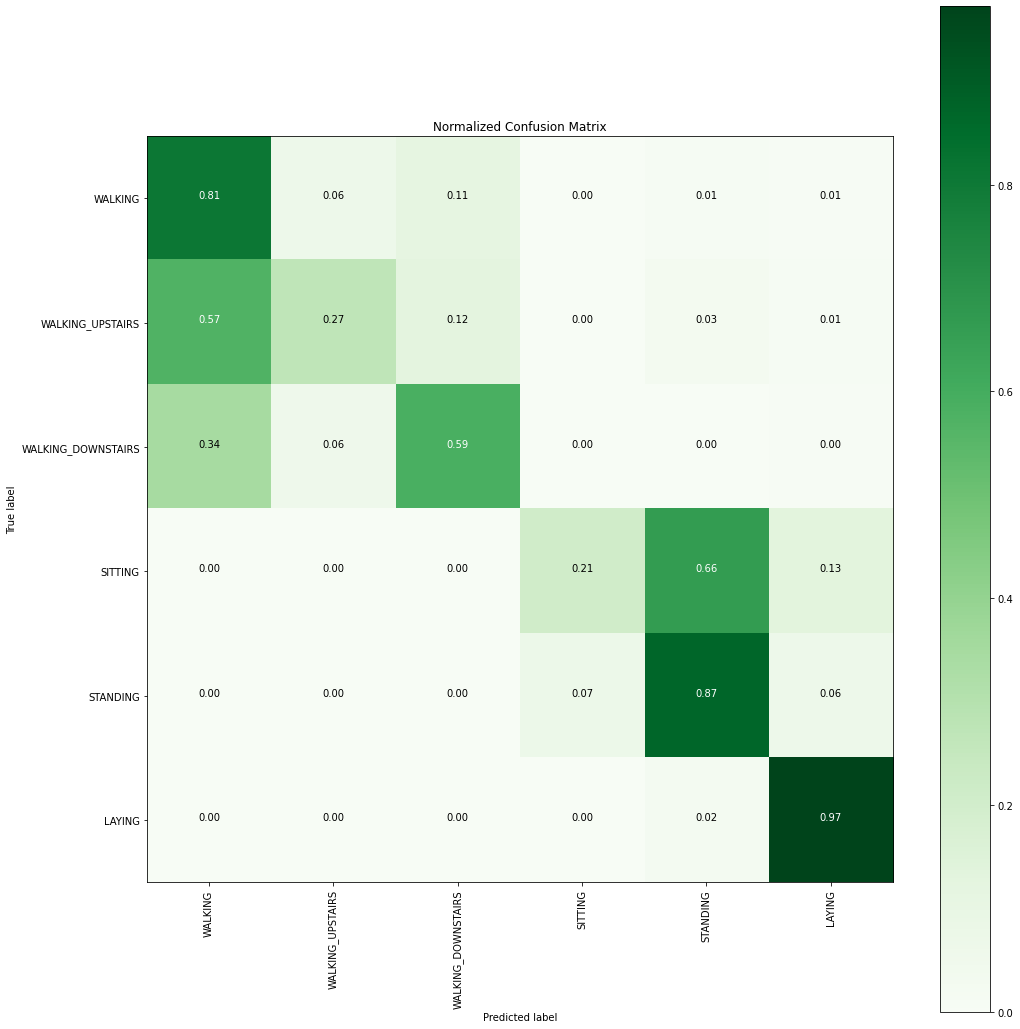


 F1 Score:0.5874175899386768


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.629487151023308
--------
epsilon:  1.2
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:02:34.554286

Predicting test data
==> testing time:- 0:00:00.054870

==> Accuracy:- 0.646865769609452


 ********Confusion Matrix********

 [[463  23  46   0   9   0]
 [261 159  57   3   9   3]
 [124  29 273   0   2   0]
 [  0   0   0  76 368  62]
 [  1   0   0  34 467  31]
 [  0   0   0   3  11 533]]


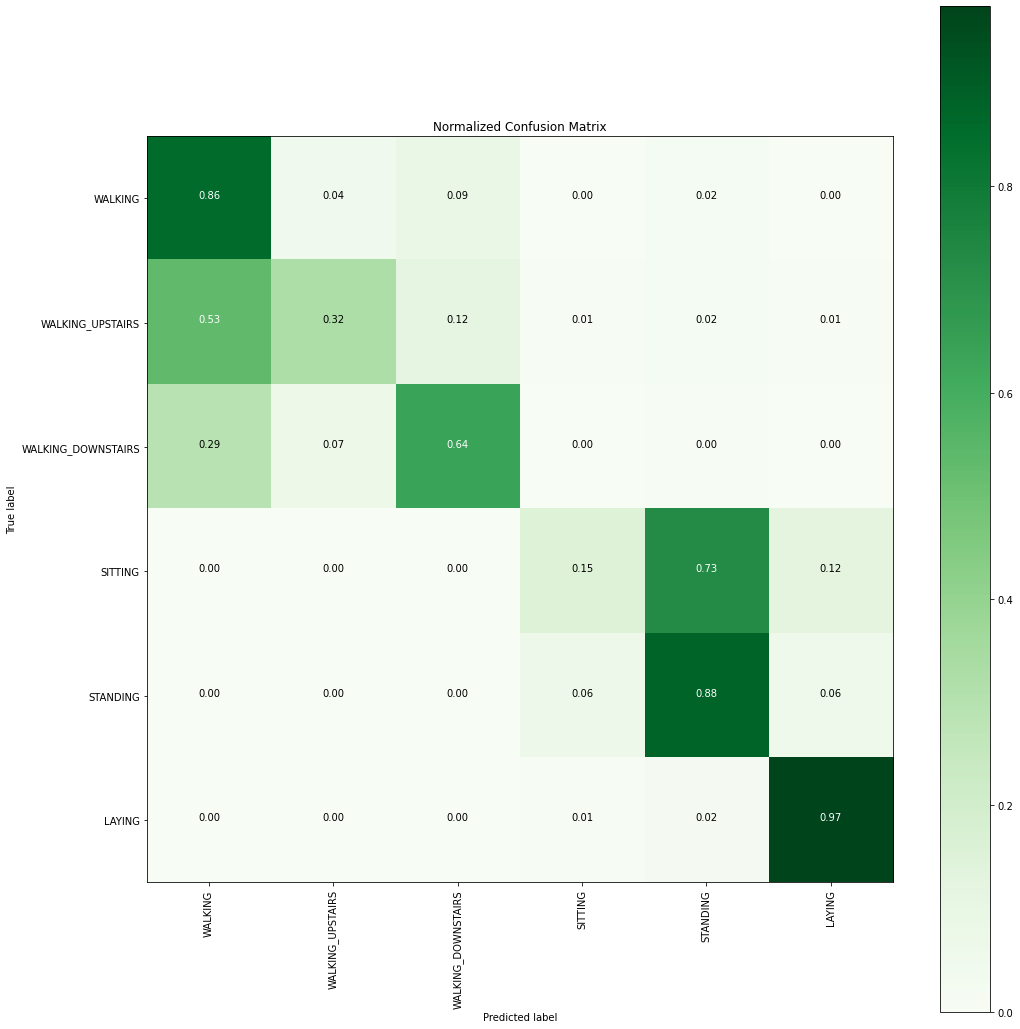


 F1 Score:0.6026823192771346


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6517958007216897
--------
epsilon:  1.3
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:02:40.890797

Predicting test data
==> testing time:- 0:00:00.077603

==> Accuracy:- 0.6603216278306531


 ********Confusion Matrix********

 [[432  49  53   0   5   2]
 [244 188  53   2   5   0]
 [108  38 280   0   2   0]
 [  0   0   0 113 328  65]
 [  0   0   0  62 462   9]
 [  0   0   0   5   5 537]]


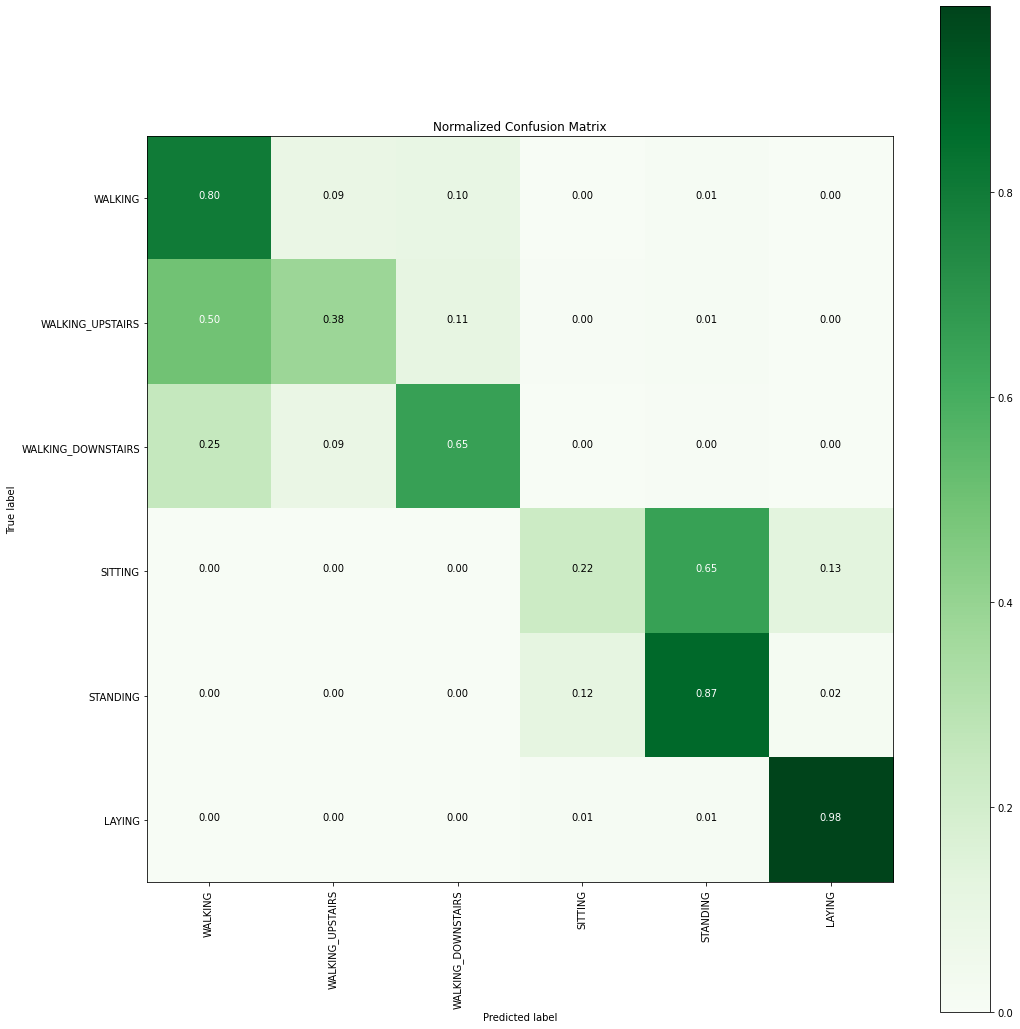


 F1 Score:0.6290267470478879


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6645640672689019
--------
epsilon:  1.4
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:05:02.609879

Predicting test data
==> testing time:- 0:00:00.065815

==> Accuracy:- 0.670495569412537


 ********Confusion Matrix********

 [[455  31  51   0   4   0]
 [257 176  47   2   7   3]
 [114  27 287   0   0   0]
 [  0   0   0 117 332  57]
 [  0   0   0  38 480  15]
 [  0   0   0  10   9 528]]


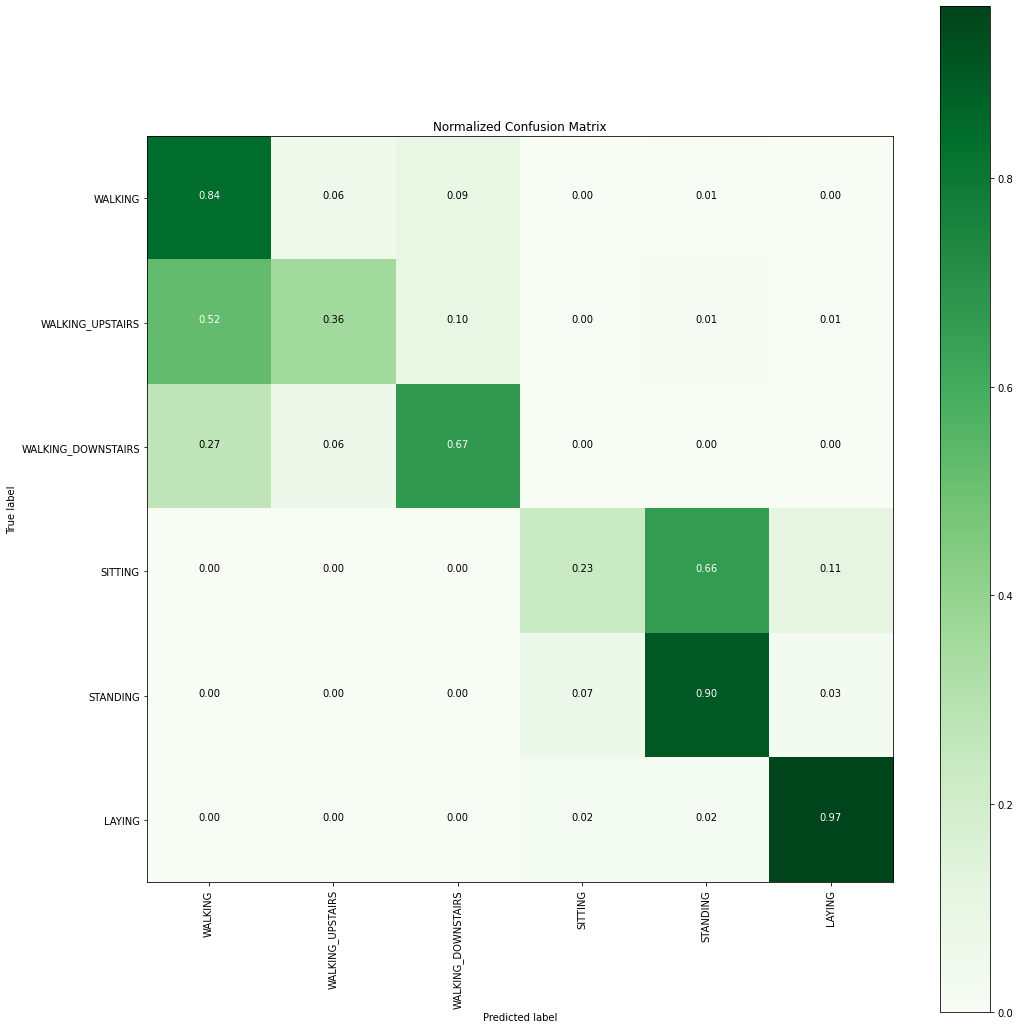


 F1 Score:0.6376368820717568


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6802444289757256
--------
epsilon:  1.5
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 1:54:32.123451

Predicting test data
==> testing time:- 0:00:00.141779

==> Accuracy:- 0.6964227108631441


 ********Confusion Matrix********

 [[446  48  44   1   1   1]
 [203 224  59   1   3   2]
 [109  30 289   0   0   0]
 [  0   0   0 141 323  42]
 [  0   0   0  45 477  11]
 [  0   0   0   1   1 545]]


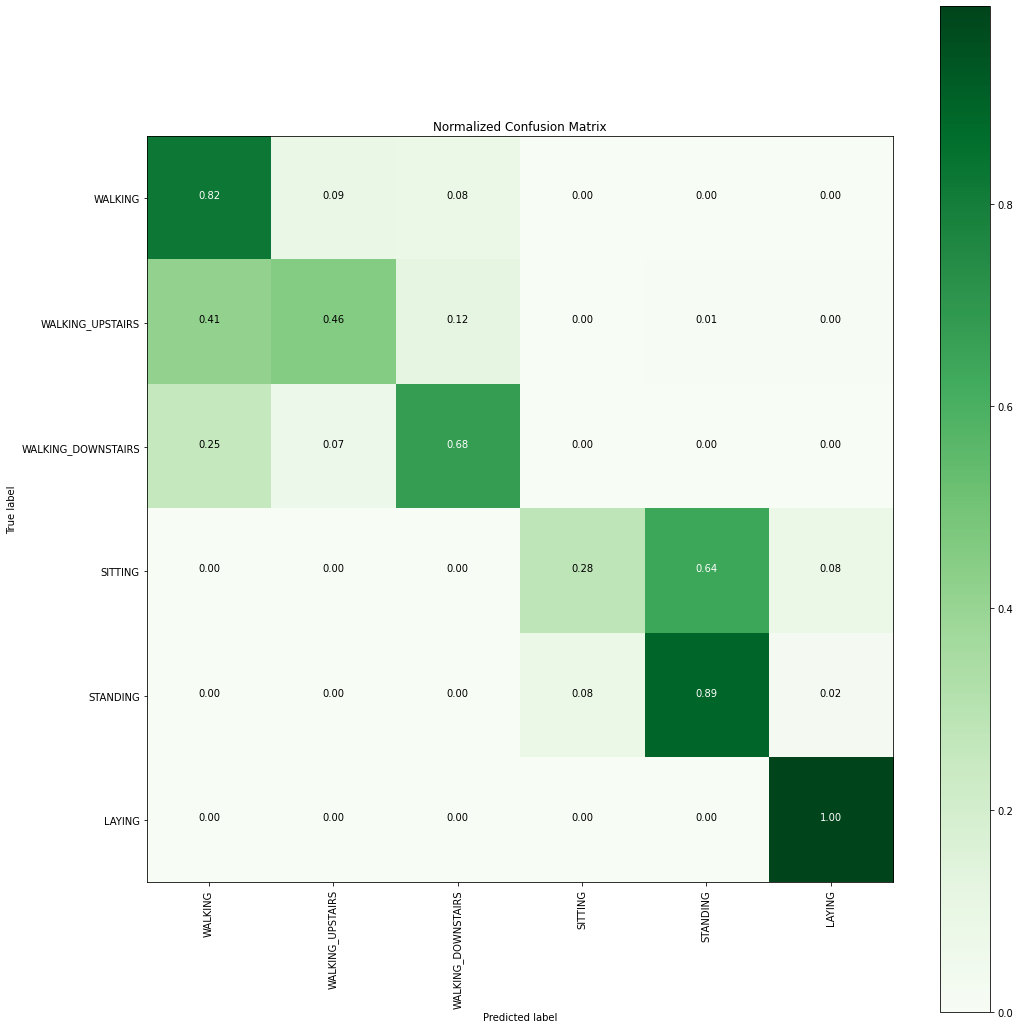


 F1 Score:0.6706715136409992


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6985123474767632
--------
epsilon:  1.8
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:02:56.104868

Predicting test data
==> testing time:- 0:00:00.109671

==> Accuracy:- 0.7381030521824745


 ********Confusion Matrix********

 [[469  32  40   0   0   0]
 [177 270  44   1   0   0]
 [ 93  42 292   0   1   0]
 [  0   0   0 191 282  33]
 [  0   0   0  42 485   6]
 [  0   0   0   4   1 542]]


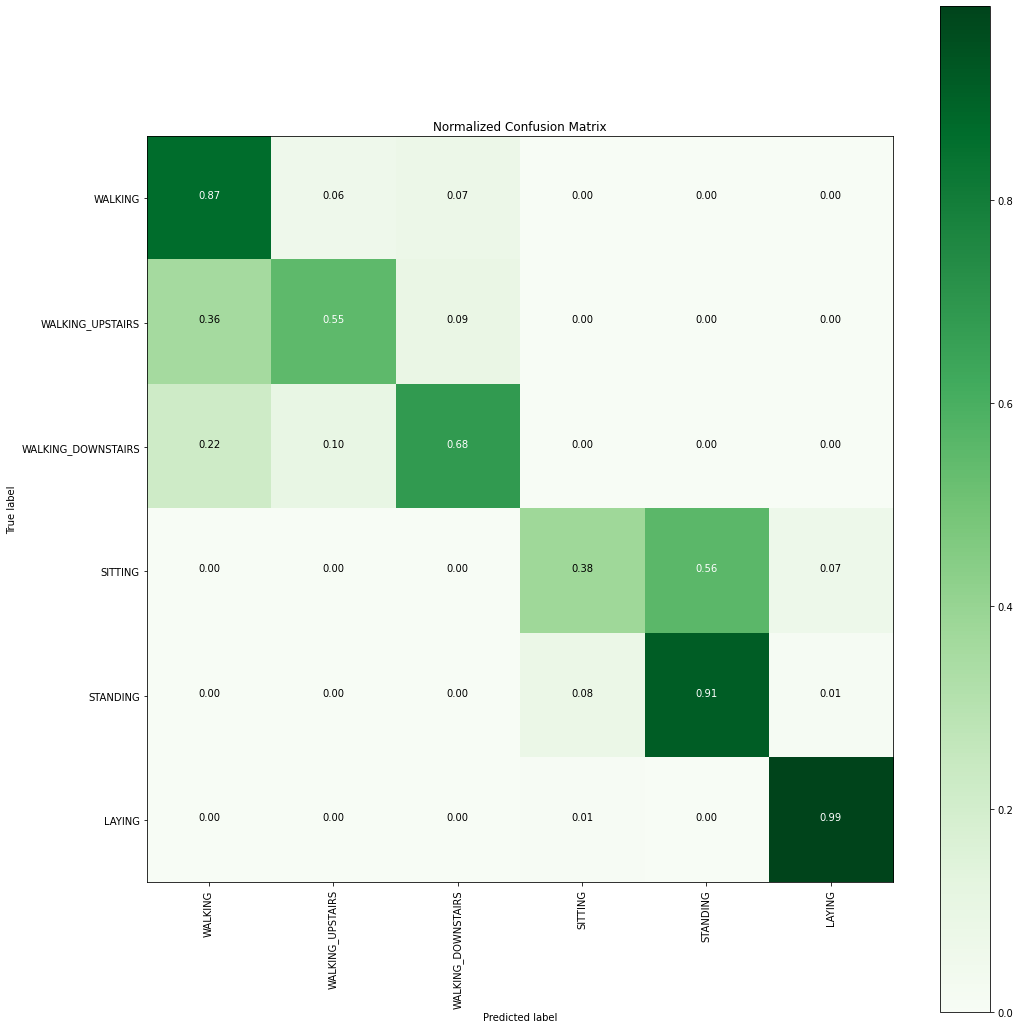


 F1 Score:0.7207591870110117


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7461996361513537
--------
epsilon:  2.0
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:02:48.575353

Predicting test data
==> testing time:- 0:00:00.115133

==> Accuracy:- 0.7436823104693141


 ********Confusion Matrix********

 [[458  46  35   1   1   0]
 [152 293  43   1   3   0]
 [ 83  50 295   0   0   0]
 [  0   0   0 226 247  33]
 [  0   0   0  75 451   7]
 [  0   0   0   3   1 543]]


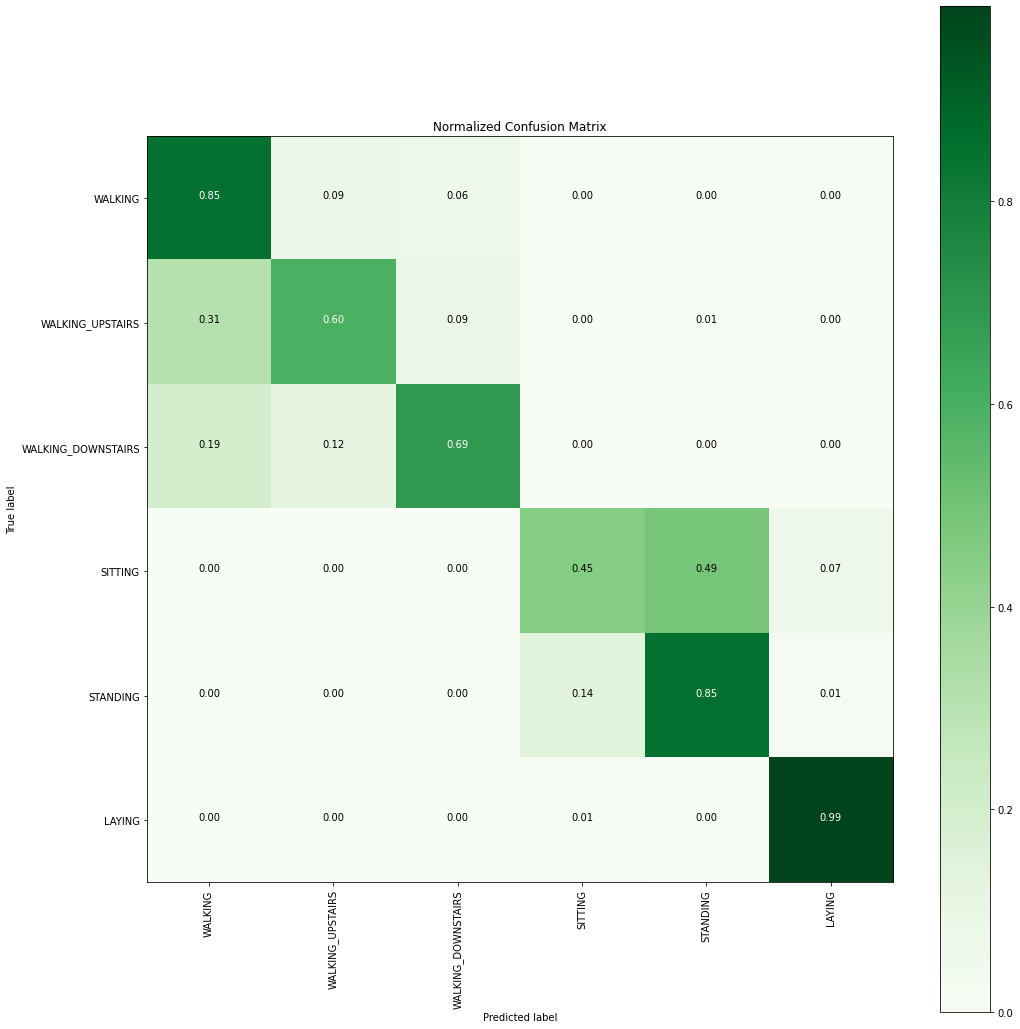


 F1 Score:0.7319199375879375


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7583257477115801
--------
epsilon:  2.2
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:02:54.350329

Predicting test data
==> testing time:- 0:00:00.103388

==> Accuracy:- 0.77125041023958


 ********Confusion Matrix********

 [[462  45  34   0   0   0]
 [127 314  49   0   2   0]
 [ 65  47 316   0   0   0]
 [  0   0   0 228 256  22]
 [  0   0   0  46 485   2]
 [  0   0   0   1   1 545]]


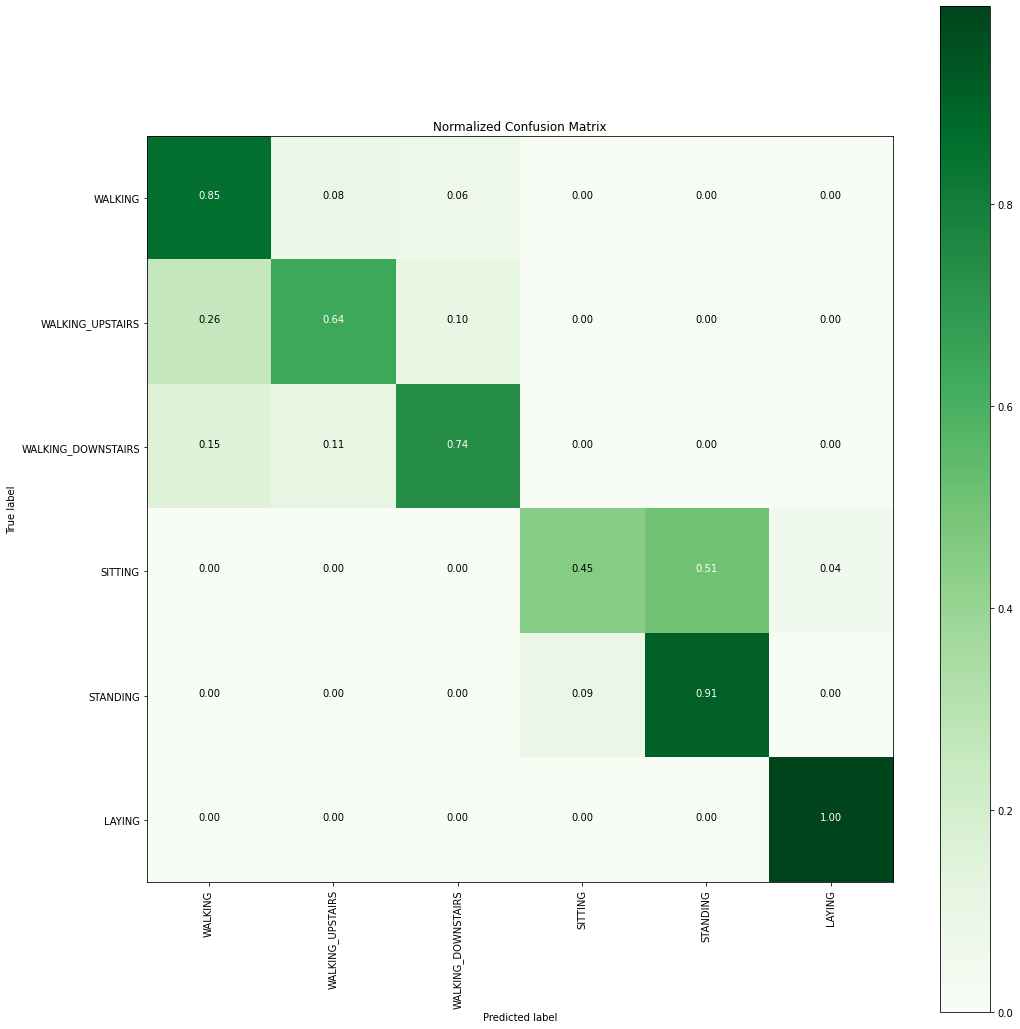


 F1 Score:0.7594872880817894


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7809572379891421
--------
epsilon:  2.5
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done
==> training time:- 0:02:54.008653

Predicting test data
==> testing time:- 0:00:00.096913

==> Accuracy:- 0.7929110600590745


 ********Confusion Matrix********

 [[476  37  27   0   1   0]
 [107 341  44   0   0   0]
 [ 66  61 301   0   0   0]
 [  0   0   0 260 218  28]
 [  0   0   0  40 492   1]
 [  0   0   0   1   0 546]]


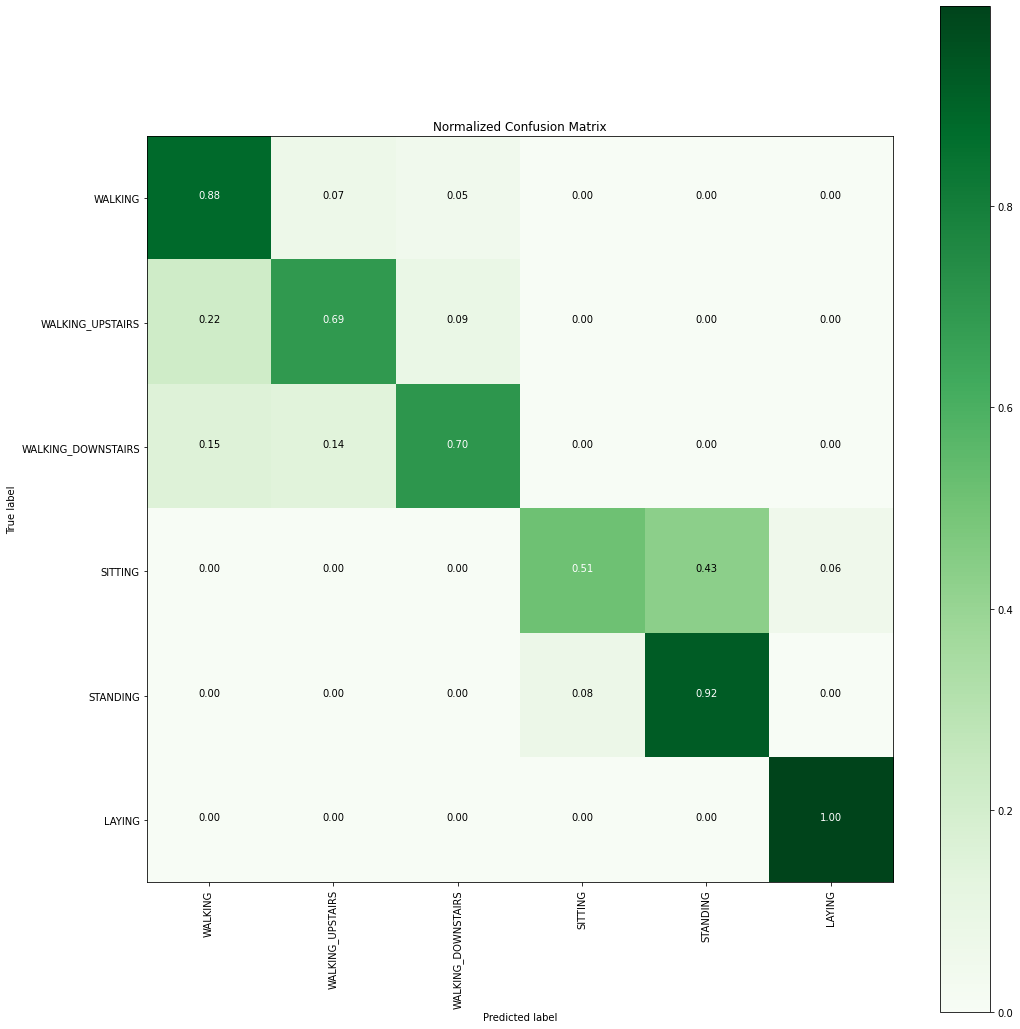


 F1 Score:0.7822777167405456


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8079549120220243


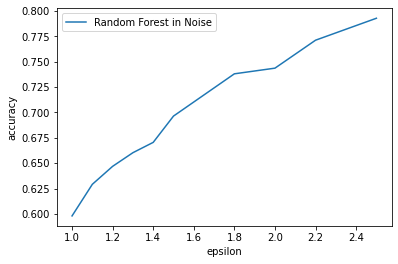

In [ ]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_har = list()


epsilons = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2.0, 2.2, 2.5]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

  for col in X_train:
      # default sensitivity = 1.0
    # if col not in f_add_weighted_noise:
    #   # print("------epsilon--------")
    #   # display(X_train[col].head())
    #   X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    #   X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    #   # display(X_train[col].head)
    # else:
    #   # print("------weighted_epsilon--------")
    #   # display(X_train[col].head())
    #   X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    #   X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    #   # display(X_train[col].head())
    if col in f_add_weighted_noise:
              # print("------epsilon--------")
      # display(X_train[col].head())
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      # display(X_train[col].head)
      # print("------weighted_epsilon--------")
      # display(X_train[col].head())
    X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    # display(X_train[col].head())
    
  # params = {'n_estimators': np.arange(120,201,20), 'max_depth':np.arange(6,15,2)}
  params = {'n_estimators': np.arange(120,151,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_act)
  acc_array_random_har.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], acc_array_random_har[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()


In [ ]:
# epsilons = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2.0, 2.2, 2.5]
print(acc_array_random_har)
print(acc_array_random_uid)

[0.5979652116836233, 0.6291434197571382, 0.646865769609452, 0.6603216278306531, 0.670495569412537, 0.6964227108631441, 0.7381030521824745, 0.7436823104693141, 0.77125041023958, 0.7929110600590745]
[0.0390548080078766, 0.04627502461437479, 0.05644896619625862, 0.06366918280275681, 0.0662947161142107, 0.07318674105677715, 0.10338037413849688, 0.1135543157203807, 0.12930751558910403, 0.14965539875287168]


In [ ]:
print(weighted_epsilon)

print(n)

0.01
211


In [ ]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()')

In [ ]:
# beep()